In [3]:
!pip install livelossplot

In [1]:
import torch
import torchvision
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from livelossplot import PlotLosses

In [2]:

class MSEloss_with_Mask(nn.Module):
  def __init__(self):
    super(MSEloss_with_Mask,self).__init__()

  def forward(self,inputs, targets):
    # Masking into a vector of 1's and 0's.
    mask = (targets!=0)
    mask = mask.float()

    # Actual number of ratings.
    # Take max to avoid division by zero while calculating loss.
    other = torch.Tensor([1.0])
    number_ratings = torch.max(torch.sum(mask),other)
    error = torch.sum(torch.mul(mask,torch.mul((targets-inputs),(targets-inputs))))
    loss = error.div(number_ratings)
    return loss[0]


### Dataset and DataLoader

In [3]:

class TestDataset(Dataset):
    def __init__(self, test_file, transform=None):
        self.data = pd.read_csv(test_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        
        if transform is not None:
            self.data = self.transform(np.array(self.data))
        
    def __len__(self):
        return len(self.data[0])
    
    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        
        return user_vector
    

class TrainDataset(Dataset):
    def __init__(self, train_file, transform=None):
        self.data = pd.read_csv(train_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        
        if transform is not None:
            self.data = self.transform(np.array(self.data))
        
    def __len__(self):
        return len(self.data[0])
    
    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        
        return user_vector

In [4]:
transformations = transforms.Compose([transforms.ToTensor()])
train_dat = TrainDataset('train_1m.csv', transformations)

print("Training Length: ", train_dat.__len__())
print("6th User Ratings: ", train_dat.__getitem__(7))

Training Length:  6039
6th User Ratings:  tensor([4., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)


In [5]:
test_dat = TestDataset('test_1m.csv', transformations)
print("Testing Length: ", test_dat.__len__())
print("6th User Ratings: ", test_dat.__getitem__(4))

Testing Length:  6039
6th User Ratings:  tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)


In [6]:
batch_size = 64
train_dl = DataLoader(dataset=train_dat, batch_size = batch_size, shuffle=False, num_workers = 1)

test_dl = DataLoader(dataset=test_dat, batch_size=batch_size, shuffle=False, num_workers=1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


### Model

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


def activation(input, type):
  
    if type.lower()=='selu':
        return F.selu(input)
    elif type.lower()=='elu':
        return F.elu(input)
    elif type.lower()=='relu':
        return F.relu(input)
    elif type.lower()=='relu6':
        return F.relu6(input)
    elif type.lower()=='lrelu':
        return F.leaky_relu(input)
    elif type.lower()=='tanh':
        return F.tanh(input)
    elif type.lower()=='sigmoid':
        return F.sigmoid(input)
    elif type.lower()=='swish':
        return F.sigmoid(input)*input
    elif type.lower()=='identity':
        return input
    else:
        raise ValueError("Unknown non-Linearity Type")


class AutoEncoder(nn.Module):

    def __init__(self, layer_sizes, nl_type='selu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=True):
        """
        layer_sizes = size of each layer in the autoencoder model
        For example: [10000, 1024, 512] will result in:
            - encoder 2 layers: 10000x1024 and 1024x512. Representation layer (z) will be 512
            - decoder 2 layers: 512x1024 and 1024x10000.
        
        nl_type = non-Linearity type (default: 'selu).
        is_constrained = If true then the weights of encoder and decoder are tied.
        dp_drop_prob = Dropout probability.
        last_layer_activations = Whether to apply activation on last decoder layer.
        """

        super(AutoEncoder, self).__init__()

        self.layer_sizes = layer_sizes
        self.nl_type = nl_type
        self.is_constrained = is_constrained
        self.dp_drop_prob = dp_drop_prob
        self.last_layer_activations = last_layer_activations

        if dp_drop_prob>0:
            self.drop = nn.Dropout(dp_drop_prob)

        self._last = len(layer_sizes) - 2

        # Initaialize Weights
        self.encoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(layer_sizes[i+1], layer_sizes[i])) for i in range(len(layer_sizes) - 1)  ] )

        # "Xavier Initialization" ( Understanding the Difficulty in training deep feed forward neural networks - by Glorot, X. & Bengio, Y. )
        # ( Values are sampled from uniform distribution )
        for weights in self.encoder_weights:
            init.xavier_uniform_(weights)

        # Encoder Bias
        self.encoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(layer_sizes[i+1])) for i in range(len(layer_sizes) - 1) ] )

        reverse_layer_sizes = list(reversed(layer_sizes)) 
        # reversed returns iterator


        # Decoder Weights
        if is_constrained == False:
            self.decoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(reverse_layer_sizes[i+1], reverse_layer_sizes[i])) for i in range(len(reverse_layer_sizes) - 1) ] )

            for weights in self.decoder_weights:
                init.xavier_uniform_(weights)

        self.decoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(reverse_layer_sizes[i+1])) for i in range(len(reverse_layer_sizes) - 1) ] )



    def encode(self,x):
        for i,w in enumerate(self.encoder_weights):
            x = F.linear(input=x, weight = w, bias = self.encoder_bias[i] )
            x = activation(input=x, type=self.nl_type)

        # Apply Dropout on the last layer
        if self.dp_drop_prob > 0:
            x = self.drop(x)

        return x


    def decode(self,x):
        if self.is_constrained == True:
            # Weights are tied
            for i,w in zip(range(len(self.encoder_weights)),list(reversed(self.encoder_weights))):
                x = F.linear(input=x, weight=w.t(), bias = self.decoder_bias[i] )
                x = activation(input=x, type=self.nl_type if i != self._last or self.last_layer_activations else 'identity')

        else:

            for i,w in enumerate(self.decoder_weights):
                x = F.linear(input=x, weight = w, bias = self.decoder_weights[i])
                x = activation(input=x, type=self.nl_type if i != self._last or self.last_layer_activations else 'identity')

        return x

    def forward(self,x):
        # Forward Pass
        return self.decode(self.encode(x))



In [86]:

layer_sizes = [3701, 512, 512, 1024]

layer_sizes = [3701, 512, 256]
model = AutoEncoder(layer_sizes=layer_sizes, nl_type='selu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=False)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [87]:


criterion = MSEloss_with_Mask()

### Train

In [77]:
def train(model, criterion, optimizer, train_dl, test_dl, num_epochs=40):
  # We will run for 40 epochs
  liveloss = PlotLosses()
  for epoch in range(num_epochs):
    train_loss, valid_loss = [], []
    logs = {}
    prefix = ''

    # Training Part
    model.train()
    for i, data in enumerate(train_dl, 0):
      # Get the inputs
      inputs = labels = data
#       inputs = inputs.cuda()
#       labels = labels.cuda()

      inputs = inputs.float()
      labels = labels.float()

      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = model(inputs)
#       outputs = outputs.cuda()
#       print(outputs.device, labels.device)
#       print(criterion.device)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      ## -> Iterative Dense Output Re-feeding <- ##
      
      # Add a "for" loop to iterate as much you want
      
      # Zero the gradiants
      optimizer.zero_grad()
      
      # Important -> detach() the output, to avoid unecessary construction of 
      # the computational graph
      outputs = model(outputs.detach())
#       outputs = outputs.cuda() 
      
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      logs[prefix + 'MMSE loss'] = loss.item()

    for i, data in enumerate(test_dl, 0):
      model.eval()
      inputs = labels = data
#       inputs = inputs.cuda()
#       labels = labels.cuda()

      inputs = inputs.float()
      labels = labels.float()

      outputs = model(inputs)
#       outputs = outputs.cuda()
      loss = criterion(outputs, labels)

      valid_loss.append(loss.item())
      prefix = 'val_'
      logs[prefix + 'MMSE loss'] = loss.item()

#     hlr2_tr_loss.append(np.mean(train_loss))
#     hlr2_val_loss.append(np.mean(valid_loss))
    liveloss.update(logs)
    liveloss.draw()
    print ("Epoch:", epoch+1, " Training Loss: ", np.mean(train_loss), " Valid Loss: ", np.mean(valid_loss))
    if epoch == num_epochs -1:
      return outputs

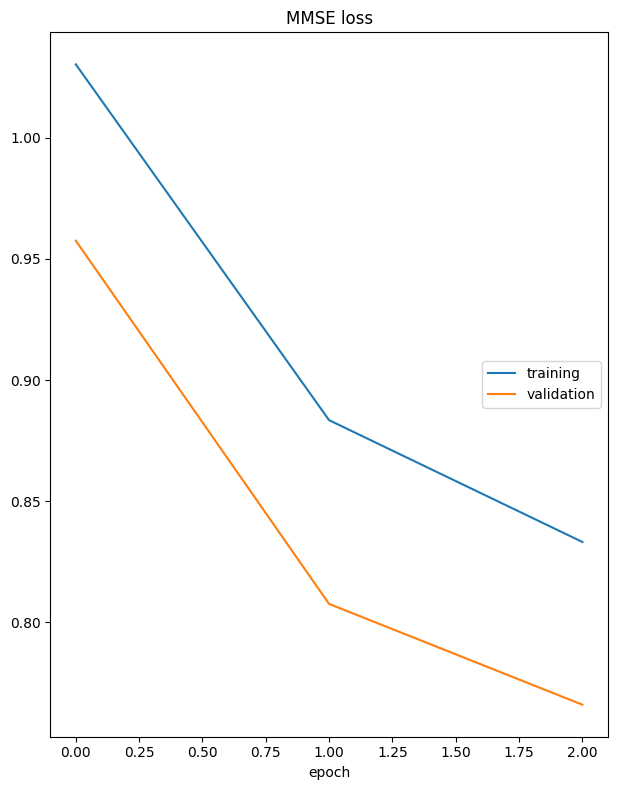

MMSE loss
	training         	 (min:    0.833, max:    1.030, cur:    0.833)
	validation       	 (min:    0.766, max:    0.958, cur:    0.766)
Epoch: 3  Training Loss:  0.9868067101428383  Valid Loss:  0.904401619810807


KeyboardInterrupt: 

In [78]:
out = train(model, criterion, optimizer, train_dl, test_dl, 40)

### Calculating Recall and HR

In [47]:

def get_HR(model, train_loader, test_loader, top_n=10):

    counter, hits = 0, 0
    r = []
    for i, (batch_train, batch_val) in enumerate(zip(iter(train_loader), iter(test_loader))):
        delta = batch_val - batch_train
        predicted_val = model(batch_train.float()) - batch_train
        for k in range(delta.shape[0]):
            non_zero_ind = np.nonzero(delta[k])
            if len(non_zero_ind) > 0:
                counter += 1
                diff = set([int(item) for item  in np.argpartition(np.array(predicted_val.detach()[k]), -top_n)[-top_n:]]) - (set([int(item) for item in non_zero_ind]))
                
                if len(diff) < top_n:
                    hits += 1
    return hits / counter

get_HR(model, train_dl, test_dl)


0.14587737843551796

In [50]:

def get_recall(model, train_loader, test_loader, top_n=50):

    counter, hits = 0, 0
    r = []
    for i, (batch_train, batch_val) in enumerate(zip(iter(train_loader), iter(test_loader))):
        delta = batch_val - batch_train
        predicted_val = model(batch_train.float()) - batch_train
        for k in range(delta.shape[0]):
            non_zero_ind = np.nonzero(delta[k])
            if len(non_zero_ind) > 0:
                counter += 1
#                 print(non_zero_ind)
                diff = set([int(item) for item  in np.argpartition(np.array(predicted_val.detach()[k]), -top_n)[-top_n:]]).intersection(set([int(item) for item in non_zero_ind]))
                
#                 diff = set([int(item) for item  in np.argpartition(np.array(predicted_val.detach()[k]), -top_n)[-top_n:]]) - set([int(non_zero_ind[0])])
        
#                 diff = set([int(item) for item  in np.argpartition(np.array(predicted_val.detach()[k]), -top_n)[-top_n:]]) - set([int(non_zero_ind[0])])
                r.append(len(diff) / len(non_zero_ind))
                if len(diff) < top_n:
                    hits += 1
    return np.mean(r)
    return hits / counter
        
get_recall(model, train_dl, test_dl)


0.043463207268371974

In [42]:
# from torchsummary import summary

# summary(model, (64, 3701), verbose=2)
from torchinfo import summary

summary(model, input_size=(batch_size, 3701), verbose=2)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [64, 3701]                2,688,117
Total params: 2,688,117
Trainable params: 2,688,117
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.95
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.95


Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [64, 3701]                2,688,117
Total params: 2,688,117
Trainable params: 2,688,117
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.95
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.95

### Jax model

In [7]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax import struct

import optax

import flax
import numpy as np
from flax import struct 
from clu import metrics
from dataclasses import field
from functools import partial
from typing import Any, Callable, Optional, Tuple, Union
from flax import struct  

from clu import metrics

from chex import Array
from flax import linen as nn
from flax.linen.activation import sigmoid, tanh
from flax.linen.dtypes import promote_dtype
from flax.linen.initializers import orthogonal
from flax.linen.linear import default_kernel_init
from jax import numpy as jnp
from jax import random, vmap
from chex import Array
from jax import lax
from jax.nn.initializers import Initializer as Initializer
from jax._src import dtypes

from flax.training import train_state

key = jax.random.PRNGKey(0)

/home/skholkin/projects/python_venv/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:

@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')
    
class TrainState(train_state.TrainState):
  metrics: Metrics

In [9]:

dim = next(iter(train_dl)).shape[1]

hidden_dim = 1000

layer_sizes = [3701, 512, 256]

class SimpleAE(nn.Module):
    
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(layer_sizes[1])(x)
    x = nn.selu(x)
    x = nn.Dense(layer_sizes[2])(x)
    x = nn.selu(x)
    x = nn.Dense(layer_sizes[1])(x)
    x = nn.selu(x)
    x = nn.Dense(layer_sizes[0])(x)
    return x

autoencoder = SimpleAE()
print(autoencoder.tabulate(jax.random.PRNGKey(42), jnp.ones((batch_size, dim))))



                                SimpleAE Summary                                
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module   ┃ inputs           ┃ outputs          ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ SimpleAE │ float32[64,3701] │ float32[64,3701] │ Dense_0:          │
│         │          │                  │                  │   bias:           │
│         │          │                  │                  │ float32[512]      │
│         │          │                  │                  │   kernel:         │
│         │          │                  │                  │ float32[3701,512] │
│         │          │                  │                  │ Dense_1:          │
│         │          │                  │                  │   bias:           │
│         │          │                  │                  │ float32[256]      │
│         │          │     

In [10]:

def create_train_state(module, rng, learning_rate):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([batch_size, dim]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

train_state = create_train_state(autoencoder, jax.random.PRNGKey(43), 1e-3)



In [11]:

def MSEMasked(inputs, targets): # Masking into a vector of 1's and 0's.
    mask = (targets!=0)
    mask = jnp.float32(mask)

    # Actual number of ratings.
    # Take max to avoid division by zero while calculating loss.
    other = jnp.array(1.0)
    number_ratings = jnp.maximum(jnp.sum(mask), other)
    error = jnp.sum(mask * (targets - inputs) ** 2)
    loss = error / number_ratings
    return loss
    
    
@jax.jit
def train_step(state, batch):
  """Train for a single step."""

  def loss_fn(params):
    x_rec = state.apply_fn({'params': params}, batch)
    loss = MSEMasked(batch, x_rec)
    return loss

  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def compute_metrics(*, state, batch):
    x_rec = state.apply_fn({'params': state.params}, batch)
    loss = ((x_rec - batch) ** 2).mean()
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

@jax.jit
def predict(state, batch):
    x_rec = state.apply_fn({'params': state.params}, batch)
    return x_rec


In [12]:

sample_batch = jnp.array(next(iter(train_dl)))

train_step(train_state, sample_batch)

train_state = compute_metrics(state=train_state, batch=sample_batch)
train_state.metrics.compute()['loss']

Array(1.2523139, dtype=float32)

In [13]:
epochs = 300
for ep in range(epochs):
    ep_loss = []
    for i, batch in enumerate(iter(train_dl)):
        batch = jnp.array(batch)
        train_state = train_step(train_state, batch)
        train_state = compute_metrics(state=train_state, batch=batch)
        metrics = train_state.metrics.compute()['loss']
        ep_loss.append(metrics)
    
    print(f'Epoch: {ep} Iter {i} Metrics: {jnp.mean(np.array(ep_loss))}')

Epoch: 0 Iter 94 Metrics: 1.2654837369918823
Epoch: 1 Iter 94 Metrics: 1.2492533922195435
Epoch: 2 Iter 94 Metrics: 1.231633186340332
Epoch: 3 Iter 94 Metrics: 1.2188681364059448
Epoch: 4 Iter 94 Metrics: 1.2087388038635254
Epoch: 5 Iter 94 Metrics: 1.200228214263916
Epoch: 6 Iter 94 Metrics: 1.192807674407959
Epoch: 7 Iter 94 Metrics: 1.1861687898635864
Epoch: 8 Iter 94 Metrics: 1.180118441581726
Epoch: 9 Iter 94 Metrics: 1.1745266914367676
Epoch: 10 Iter 94 Metrics: 1.1693040132522583
Epoch: 11 Iter 94 Metrics: 1.1643840074539185
Epoch: 12 Iter 94 Metrics: 1.1597177982330322
Epoch: 13 Iter 94 Metrics: 1.1552667617797852
Epoch: 14 Iter 94 Metrics: 1.1510013341903687
Epoch: 15 Iter 94 Metrics: 1.1468963623046875
Epoch: 16 Iter 94 Metrics: 1.1429322957992554
Epoch: 17 Iter 94 Metrics: 1.1390928030014038
Epoch: 18 Iter 94 Metrics: 1.1353641748428345
Epoch: 19 Iter 94 Metrics: 1.1317347288131714
Epoch: 20 Iter 94 Metrics: 1.128193736076355
Epoch: 21 Iter 94 Metrics: 1.1247330904006958
Epo

Epoch: 178 Iter 94 Metrics: 0.8254687190055847
Epoch: 179 Iter 94 Metrics: 0.824424684047699
Epoch: 180 Iter 94 Metrics: 0.8233870267868042
Epoch: 181 Iter 94 Metrics: 0.8223552703857422
Epoch: 182 Iter 94 Metrics: 0.8213297128677368
Epoch: 183 Iter 94 Metrics: 0.820310115814209
Epoch: 184 Iter 94 Metrics: 0.8192968368530273
Epoch: 185 Iter 94 Metrics: 0.8182895183563232
Epoch: 186 Iter 94 Metrics: 0.8172877430915833
Epoch: 187 Iter 94 Metrics: 0.8162919282913208
Epoch: 188 Iter 94 Metrics: 0.8153018951416016
Epoch: 189 Iter 94 Metrics: 0.8143177628517151
Epoch: 190 Iter 94 Metrics: 0.8133392930030823
Epoch: 191 Iter 94 Metrics: 0.8123665452003479
Epoch: 192 Iter 94 Metrics: 0.8113994598388672
Epoch: 193 Iter 94 Metrics: 0.8104376792907715
Epoch: 194 Iter 94 Metrics: 0.8094813823699951
Epoch: 195 Iter 94 Metrics: 0.8085306882858276
Epoch: 196 Iter 94 Metrics: 0.8075851202011108
Epoch: 197 Iter 94 Metrics: 0.806644856929779
Epoch: 198 Iter 94 Metrics: 0.8057100176811218
Epoch: 199 Iter 

In [14]:

ep_loss = []
for i, batch in enumerate(iter(test_dl)):
    batch = jnp.array(batch)
    train_state = train_step(train_state, batch)
    train_state = compute_metrics(state=train_state, batch=batch)
    metrics = train_state.metrics.compute()['loss']
    ep_loss.append(metrics)

print(f'Epoch: {ep} Iter {i} Metrics: {jnp.mean(np.array(ep_loss))}')


Epoch: 299 Iter 94 Metrics: 0.7318029403686523


In [19]:

def get_HR_jax(state, train_loader, test_loader, top_n=10):

    counter, hits = 0, 0
    r = []
    for i, (batch_train, batch_val) in enumerate(zip(iter(train_loader), iter(test_loader))):
        batch_train, batch_val = jnp.array(batch_train), jnp.array(batch_val)
        delta = batch_val - batch_train
        x_rec = state.apply_fn({'params': state.params}, batch_train)
        
        for k in range(delta.shape[0]):
            non_zero_ind = np.nonzero(np.array(delta[k]))[0]
            if len(non_zero_ind) > 0:
                counter += 1
                diff = set([int(item) for item  in np.argpartition(np.array(x_rec[k]).reshape(-1), -top_n)[-top_n:]]) - (set([int(item) for item in non_zero_ind]))
                
                if len(diff) < top_n:
                    hits += 1
    return hits / counter

def get_recall_jax(state, train_loader, test_loader, top_n=50):

    counter, hits = 0, 0
    r = []
    for i, (batch_train, batch_val) in enumerate(zip(iter(train_loader), iter(test_loader))):
        batch_train, batch_val = jnp.array(batch_train), jnp.array(batch_val)
        delta = batch_val - batch_train
        
        x_rec = state.apply_fn({'params': state.params}, batch_train)
        
        for k in range(delta.shape[0]):
            non_zero_ind = np.nonzero(np.array(delta[k]))[0]
            if len(non_zero_ind) > 0:
                counter += 1
                diff = set([int(item) for item in  np.argpartition(np.array(x_rec[k]).reshape(-1), -top_n)[-top_n:]]).intersection(set([int(item) for item in non_zero_ind]))
                r.append(len(diff) / len(non_zero_ind))
                if len(diff) < top_n:
                    hits += 1
    return np.mean(r)
        
get_recall_jax(train_state, train_dl, test_dl)

print(f'R@50: {get_recall_jax(train_state, train_dl, test_dl, top_n=50)} HR@10: {get_HR_jax(train_state, train_dl, test_dl, top_n=10)}')


R@50: 0.07524786442144529 HR@10: 0.27906976744186046


### Hyperbolic AE (Unfortunately it is not working)

In [38]:

in_dim, out_dim = 3701, 3701

hidden_dim = 256

dims = [in_dim, hidden_dim, out_dim]
c = -1

class PoincareSimpleAE(nn.Module):
    
    param_dtype = jnp.float32
    kernel_init: Callable = default_kernel_init
    bias_init: Callable = nn.initializers.uniform(scale= 1 / jnp.sqrt(in_dim))
        
    in_dim, out_dim = in_dim, out_dim
    hidden_dim = hidden_dim
    c = c
    act = nn.relu
    
    def setup(self):
        self.scalars_1 = self.param(
            "scalars@1",
            self.kernel_init,
            (self.hidden_dim, self.in_dim),
            self.param_dtype,
        )
        
        self.bias_poincare_1 = self.param(
            "bias_poincare@1",
            self.bias_init,
            (self.hidden_dim,),
            self.param_dtype,
        )
        
        self.scalars_2 = self.param(
            "scalars@2",
            self.kernel_init,
            (self.out_dim, self.hidden_dim),
            self.param_dtype,
        )
    
        self.bias_poincare_2 = self.param(
            "bias_poincare@2",
            self.bias_init,
            (self.out_dim,),
            self.param_dtype,
        )
        
        self.balls = {'bias_poincare@1': PoincareBall(self.hidden_dim, self.c),
                      'bias_poincare@2': PoincareBall(self.out_dim, self.c)}
        
        ball_in = PoincareBall(self.in_dim, self.c)
        self.matvec_1 = jax.vmap(ball_in.mobius_matvec, in_axes=(None, 0), out_axes=0)
        
        ball_hidden = PoincareBall(self.hidden_dim, self.c)
        self.add_1 = jax.vmap(ball_hidden.mobius_add, in_axes=(None, 0), out_axes=0)
        self.log_hidden = jax.vmap(ball_hidden.log, in_axes=(None, 0), out_axes=0)
        self.exp_hidden = jax.vmap(ball_hidden.exp, in_axes=(None, 0), out_axes=0)
        
        self.matvec_2 = jax.vmap(ball_hidden.mobius_matvec, in_axes=(None, 0), out_axes=0)
        ball_out = PoincareBall(self.out_dim, self.c)
        self.add_2 = jax.vmap(ball_out.mobius_add, in_axes=(None, 0), out_axes=0)

    def __call__(self, x):
        
        Ax = self.matvec_1(self.scalars_1, x)
        Ax_b = self.add_1(self.bias_poincare_1, Ax)
        
        activation_hid = self.log_hidden(jnp.zeros([Ax_b.shape[1]]), Ax_b)
        activation_hid = nn.relu(activation_hid)
        activation_hid = self.exp_hidden(jnp.zeros([Ax_b.shape[1]]), Ax_b)

        output = self.matvec_2(self.scalars_2, activation_hid)
        output = self.add_2(self.bias_poincare_2, output)
        return output

In [45]:

from rieoptax.geometry.hyperbolic import PoincareBall

from flax.training import train_state
class TrainStateRiemannianMLP(train_state.TrainState):
    metrics: Metrics
    balls = {'bias_poincare@1': PoincareBall(hidden_dim, c),
                  'bias_poincare@2': PoincareBall(out_dim, c)}
    
    def apply_gradients(self, *, grads, **kwargs):
        """Updates `step`, `params`, `opt_state` and `**kwargs` in return value.

        Note that internally this function calls `.tx.update()` followed by a call
        to `optax.apply_updates()` to update `params` and `opt_state`.

        Args:
          grads: Gradients that have the same pytree structure as `.params`.
          **kwargs: Additional dataclass attributes that should be `.replace()`-ed.

        Returns:
          An updated instance of `self` with `step` incremented by one, `params`
          and `opt_state` updated by applying `grads`, and additional attributes
          replaced as specified by `kwargs`.
        """
        updates, new_opt_state = self.tx.update(
            grads, self.opt_state, self.params)
        
        
        poincare_param_names = self.balls.keys()
        r_grad_poincare_bias, old_bias_params = {}, {}
        for name in poincare_param_names:
            
            old_bias_params[name] = self.params[name]
            bias_poincare_grads = updates[name]
            r_grad_poincare_bias[name] = self.balls[name].egrad_to_rgrad(old_bias_params[name], bias_poincare_grads)
        
        updates = updates.unfreeze()
        for name in poincare_param_names:
            updates[name] = r_grad_poincare_bias[name]
            
        updates = flax.core.frozen_dict.freeze(updates)
        
        new_params = optax.apply_updates(self.params, updates)
        
        lr = self.lr
        new_params = new_params.unfreeze()
        for name in poincare_param_names:
            bias_poincare_new = new_params[name]
            tv = lr * r_grad_poincare_bias[name]
            new_params[name] = self.balls[name].exp(old_bias_params[name], tv)
        
        new_params = flax.core.frozen_dict.freeze(new_params)
        
        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state=new_opt_state,
            **kwargs,
        )


In [46]:

def create_train_state(module, rng, learning_rate):
  """Creates an initial `TrainState`."""
  from flax.training import train_state
  class TrainState(TrainStateRiemannianMLP):
    metrics: Metrics
    lr = learning_rate
  params = module.init(rng, jnp.ones([batch_size, in_dim]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())


def MSEMasked(inputs, targets): # Masking into a vector of 1's and 0's.
    mask = (targets!=0)
    mask = jnp.float32(mask)

    # Actual number of ratings.
    # Take max to avoid division by zero while calculating loss.
    other = jnp.array(1.0)
    number_ratings = jnp.maximum(jnp.sum(mask), other)
    error = jnp.sum(mask * (targets - inputs) ** 2)
    loss = error / number_ratings
    return loss

@jax.jit
def train_step(state, batch):
  """Train for a single step."""

  def loss_fn(params):
    x_rec = state.apply_fn({'params': params}, batch)
    loss = MSEMasked(batch, x_rec)
    return loss
  
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def compute_metrics(*, state, batch):
    x_rec = state.apply_fn({'params': state.params}, batch)
    loss = MSEMasked(batch, x_rec)
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state



In [64]:

poincare_ae = PoincareSimpleAE()
train_state = create_train_state(poincare_ae, jax.random.PRNGKey(42), 1e-03)


In [67]:

epochs = 300
for ep in range(epochs):
    ep_loss = []
    for i, batch in enumerate(iter(train_dl)):
        batch = jnp.array(batch)
#         print(jnp.linalg.norm(batch, axis=1))
        batch = jnp.divide(batch, jnp.expand_dims(jnp.linalg.norm(batch, axis=1), axis=1) + 1e-5)
#         print(jnp.linalg.norm(batch, axis=1))
        train_state = train_step(train_state, batch)
        train_state = compute_metrics(state=train_state, batch=batch)
        metrics = train_state.metrics.compute()['loss']
        ep_loss.append(metrics)
    
    print(f'Epoch: {ep} Iter {i} Metrics: {jnp.mean(np.array(ep_loss))}')
        

Epoch: 0 Iter 94 Metrics: 0.0004129254666622728
Epoch: 1 Iter 94 Metrics: 0.00041290681110695004
Epoch: 2 Iter 94 Metrics: 0.00041289953514933586
Epoch: 3 Iter 94 Metrics: 0.00041289563523605466
Epoch: 4 Iter 94 Metrics: 0.0004128931905142963
Epoch: 5 Iter 94 Metrics: 0.0004128915898036212
Epoch: 6 Iter 94 Metrics: 0.00041289033833891153
Epoch: 7 Iter 94 Metrics: 0.00041288946522399783
Epoch: 8 Iter 94 Metrics: 0.00041288885404355824
Epoch: 9 Iter 94 Metrics: 0.00041288833017461
Epoch: 10 Iter 94 Metrics: 0.00041288789361715317
Epoch: 11 Iter 94 Metrics: 0.00041288757347501814
Epoch: 12 Iter 94 Metrics: 0.00041288742795586586
Epoch: 13 Iter 94 Metrics: 0.0004128873406443745
Epoch: 14 Iter 94 Metrics: 0.0004128873406443745
Epoch: 15 Iter 94 Metrics: 0.0004128873406443745
Epoch: 16 Iter 94 Metrics: 0.0004128872824367136


KeyboardInterrupt: 

In [ ]:

def get_HR_jax(state, train_loader, test_loader, top_n=10):

    counter, hits = 0, 0
    r = []
    for i, (batch_train, batch_val) in enumerate(zip(iter(train_loader), iter(test_loader))):
        batch_train, batch_val = jnp.array(batch_train), jnp.array(batch_val)
        delta = batch_val - batch_train
        x_rec = state.apply_fn({'params': state.params}, batch_train)
        
        for k in range(delta.shape[0]):
            non_zero_ind = np.nonzero(np.array(delta[k]))[0]
            if len(non_zero_ind) > 0:
                counter += 1
                diff = set([int(item) for item  in np.argpartition(np.array(x_rec[k]).reshape(-1), -top_n)[-top_n:]]) - (set([int(item) for item in non_zero_ind]))
                
                if len(diff) < top_n:
                    hits += 1
    return hits / counter

def get_recall_jax(state, train_loader, test_loader, top_n=50):

    counter, hits = 0, 0
    r = []
    for i, (batch_train, batch_val) in enumerate(zip(iter(train_loader), iter(test_loader))):
        batch_train, batch_val = jnp.array(batch_train), jnp.array(batch_val)
        delta = batch_val - batch_train
        
        x_rec = state.apply_fn({'params': state.params}, batch_train)
        
        for k in range(delta.shape[0]):
            non_zero_ind = np.nonzero(np.array(delta[k]))[0]
            if len(non_zero_ind) > 0:
                counter += 1
                diff = set([int(item) for item in  np.argpartition(np.array(x_rec[k]).reshape(-1), -top_n)[-top_n:]]).intersection(set([int(item) for item in non_zero_ind]))
                r.append(len(diff) / len(non_zero_ind))
                if len(diff) < top_n:
                    hits += 1
    return np.mean(r)
        
get_recall_jax(train_state, train_dl, test_dl)

print(f'R@50: {get_recall_jax(train_state, train_dl, test_dl)} HR@10: {get_HR_jax(train_state, train_dl, test_dl, top_n=10)}')